# duel-q-learning-agent

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.disable_eager_execution()
sns.set()

In [15]:
df = pd.read_csv('/Users/gkumargaur/workspace/python/gitprojects/Stock-Prediction-Models/dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2020-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2020-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2020-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2020-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [16]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.compat.v1.reset_default_graph()
        self.sess = tf.compat.v1.InteractiveSession()
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size])
        feed = tf.compat.v1.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.compat.v1.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.compat.v1.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(input_tensor=feed_action,axis=1,keepdims=True))
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [17]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.app

epoch: 10, total rewards: 1062.495183.3, cost: 0.433255, total money: 3488.815129
epoch: 20, total rewards: 1550.285222.3, cost: 0.200012, total money: 3983.475163
epoch: 30, total rewards: 1530.455324.3, cost: 0.126911, total money: 4871.355287
epoch: 40, total rewards: 1201.835208.3, cost: 0.096327, total money: 4542.735171
epoch: 50, total rewards: 1422.545352.3, cost: 0.169600, total money: 4823.875369
epoch: 60, total rewards: 1393.095401.3, cost: 0.063358, total money: 4831.225344
epoch: 70, total rewards: 1464.775211.3, cost: 0.045651, total money: 4790.695193
epoch: 80, total rewards: 1179.595279.3, cost: 0.035135, total money: 5430.745242
epoch: 90, total rewards: 1110.565188.3, cost: 0.028609, total money: 5355.705141
epoch: 100, total rewards: 1278.735173.3, cost: 0.025076, total money: 4601.355107
epoch: 110, total rewards: 1057.285099.3, cost: 0.025078, total money: 4440.155033
epoch: 120, total rewards: 1376.615238.3, cost: 0.015351, total money: 5621.755191
epoch: 130, t

In [18]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 762.020020, total balance 9237.979980
day 4: buy 1 unit at price 790.510010, total balance 8447.469970
day 6: buy 1 unit at price 762.559998, total balance 7684.909972
day 10: buy 1 unit at price 764.479980, total balance 6920.429992
day 11: buy 1 unit at price 771.229980, total balance 6149.200012
day 12, sell 1 unit at price 760.539978, investment -0.194226 %, total balance 6909.739990,
day 13: buy 1 unit at price 769.200012, total balance 6140.539978
day 14, sell 1 unit at price 768.270020, investment -2.813372 %, total balance 6908.809998,
day 15: buy 1 unit at price 760.989990, total balance 6147.820008
day 16, sell 1 unit at price 761.679993, investment -0.115401 %, total balance 6909.500001,
day 18, sell 1 unit at price 770.840027, investment 0.831944 %, total balance 7680.340028,
day 20: buy 1 unit at price 747.919983, total balance 6932.420045
day 22: buy 1 unit at price 762.520020, total balance 6169.900025
day 23: buy 1 unit at price 759.109985, to

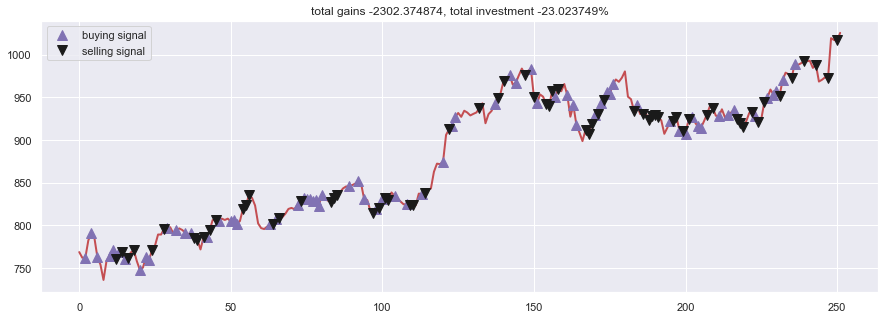

In [19]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()